In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cufflinks as cf
cf.go_offline()
import seaborn as sns
import plotly.express as px

In [3]:
%matplotlib inline

In [4]:
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [5]:
df = pd.read_excel("orders_solar.xlsx")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5869 entries, 0 to 5868
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5869 non-null   int64  
 1   type                      5869 non-null   object 
 2   created_at                5869 non-null   object 
 3   address                   5869 non-null   object 
 4   city                      5869 non-null   object 
 5   state                     5869 non-null   object 
 6   zipcode                   5869 non-null   object 
 7   full_address              5869 non-null   object 
 8   total                     5869 non-null   float64
 9   shipping                  5869 non-null   float64
 10  tax                       5869 non-null   float64
 11  shipping_method           5869 non-null   object 
 12  payment_method            5802 non-null   object 
 13  status                    5869 non-null   object 
 14  link    

In [7]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [8]:
def extract_date(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    df['year'] = df[column_name].dt.year
    df['month'] = df[column_name].dt.month
    df['day'] = df[column_name].dt.day
    return df
df = extract_date(df, 'created_at')

In [52]:
df['weekday'] = df['created_at'].dt.weekday
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['weekday'] = df['weekday'].map(dmap)

In [53]:
df.head()

,id,type,created_at,address,city,state,zipcode,full_address,total,shipping,...,solar charge controllers,solar system addons,solar panel systems,wholesale solar panels,racking,brands,year,month,day,weekday
0,18599,order,2023-06-13 18:57:11+00:00,4321 188th Place,Country Club Hills,IL,60478,4321 188th Place; Country Club Hills; IL 60478,700.01,0.0,...,0,0,0,0,0,meyer burger,2023,6,13,Tue
1,18598,order,2023-06-13 14:48:58+00:00,1215 Quail Ridge Drive,Dripping Springs,TX,78620,1215 Quail Ridge Drive; Dripping Springs; TX 7...,2212.53,250.0,...,0,0,0,0,0,hanwha q cells,2023,6,13,Tue
2,18597,order,2023-06-13 14:35:08+00:00,92 Smith Rd,East Haddam,CT,6423,92 Smith Rd; East Haddam; CT 06423,1138.38,0.0,...,0,0,0,0,0,trina solar,2023,6,13,Tue
3,18596,order,2023-06-13 13:59:49+00:00,Pembroke Rd,Miramar,FL,33025,Pembroke Rd; Miramar; FL 33025,1089.78,0.0,...,0,0,0,0,0,hanwha q cells,2023,6,13,Tue
4,18595,order,2023-06-13 02:38:18+00:00,46 Saunders Rd.,Franklin,NC,28734,46 Saunders Rd.; Franklin; NC 28734,5930.16,700.0,...,0,0,0,0,0,aptos solar,2023,6,13,Tue


Эта функция в итоге не нужна. Оказалось проще поправить формат нужных столбцов в эксель. 

from datetime import datetime

def convert_column_to_float(dataframe, column_name):
    for index, value in enumerate(dataframe[column_name]):
        if isinstance(value, str):
            try:
                dataframe.at[index, column_name] = float(value)
            except ValueError:
                pass
        elif isinstance(value, datetime):
            dataframe.at[index, column_name] = value.timestamp()
    dataframe[column_name] = dataframe[column_name].astype(float)

convert_column_to_float(df, 'total')

df.info()

In [10]:
df_geo = df.groupby('state')['total'].sum().reset_index()

In [11]:
data = dict(type='choropleth',
            colorscale = 'YlGnBu',
            locations = df_geo['state'],
            z = df_geo['total'],
            locationmode = 'USA-states',
            text = df_geo['total'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Общая сумма заказов по штатам"}
            ) 

In [12]:
layout = dict(title = 'Общая сумма заказов по штатам',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

In [13]:
choromap = go.Figure(data = [data],layout = layout)

In [14]:
iplot(choromap)

По сумме стоимости заказов по штатам мы видим, что явные лидеры (в порядке убывания): Калифорния, Флорида и Техас. 

Посмотрим, как распределены неуспешные заказы по штатам. Для этого отберем из датасета заказы и заявки со статусом declined, canceled, failed, returned и expired.  

In [15]:
df2 = df[(df['status'] == 'canceled') | (df['status'] == 'declined') | (df['status'] == 'failed') | (df['status'] == 'returned') | (df['status'] == 'expired')]

In [16]:
df2_geo = df2.groupby('state')['total'].sum().reset_index()

In [17]:
data = dict(type='choropleth',
            colorscale = 'YlGnBu',
            locations = df2_geo['state'],
            z = df2_geo['total'],
            locationmode = 'USA-states',
            text = df2_geo['total'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Общая сумма неуспешных заказов по штатам"}
            ) 

In [18]:
layout = dict(title = 'Общая сумма неуспешных заказов по штатам',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

In [19]:
choromap = go.Figure(data = [data],layout = layout)

In [20]:
iplot(choromap)

Среди неуспешных заказов выделяется Алабама и Огайо - там довольно высокая доля заказов по тем или иным причинам не завершивихся успешно. Возможно, стоит обратить на это внимание.

In [21]:
df_tax = df.groupby('state')['tax'].sum().reset_index()

In [22]:
data = dict(type='choropleth',
            colorscale = 'YlGnBu',
            locations = df_tax['state'],
            z = df_tax['tax'],
            locationmode = 'USA-states',
            text = df_tax['tax'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Налоги по штатам"}
            ) 

In [23]:
layout = dict(title = 'Налоги по штатам',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

In [24]:
choromap = go.Figure(data = [data],layout = layout)

In [25]:
iplot(choromap)

Если сравнить карту по сумме заказов и сумме налогов, то, ожидаемо лидируют Калифорния и Флорида и там и там. Интересно, что интересно, в Техасе несмотря на довольно заметное число заказов сумма налогов довольно низка. 

In [26]:
df3 = df[df['state'].isin(['TX', 'CA', 'FL'])]

In [27]:
df3_tax = df3.groupby('state')[['tax', 'total']].sum().reset_index()
df3_tax['tax_ratio'] = df3_tax['tax'] / df3_tax['total']
df3_tax

,state,tax,total,tax_ratio
0,CA,1582566.47,9959987.96,0.158892
1,FL,504982.32,3272422.52,0.154315
2,TX,11520.42,2727333.14,0.004224


Мы видим, что в Калифорнии и Флориде налоги составляют примерно одинаковую долю от общей суммы заказа, в том время как в Техасе - 0,4%. Связано это, скорее всего, со стимулирующей программой штата по использованию возобновляемых источников энергии. 
В частности, Reuters полагает, что Техас может стать лидером по росту использования солнечных панелей благодаря этой политике. https://www.reuters.com/default/texas-solar-boom-turns-battery-dash-grid-pain-looms-2023-03-15/

<AxesSubplot:xlabel='type', ylabel='count'>

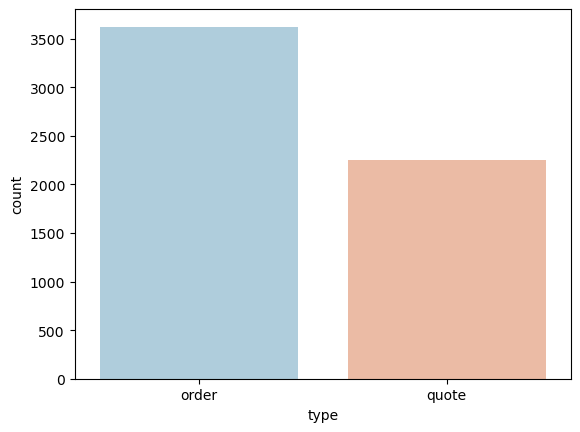

In [28]:
sns.countplot(x='type',data=df,palette='RdBu_r')

<AxesSubplot:xlabel='type', ylabel='count'>

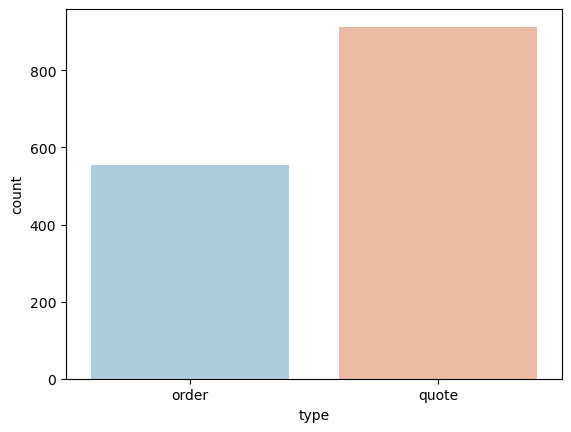

In [29]:
sns.countplot(x='type',data=df2,palette='RdBu_r')

Среди неуспешных доставок ожидаемо преобладают "заявки", в то время как в общем датасете - заказы. Однако на мэта информация не дает никаких дополнительных инсайтов.

<AxesSubplot:xlabel='shipping_method', ylabel='count'>

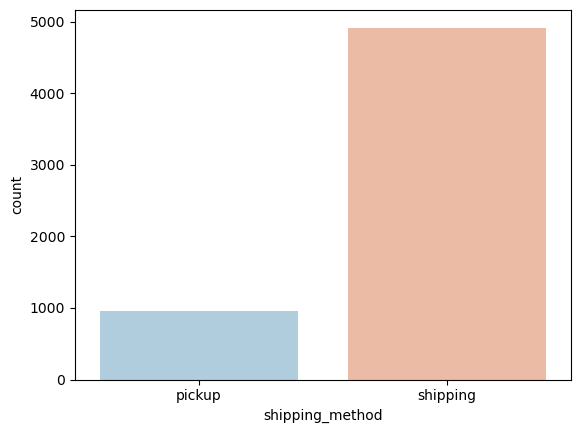

In [30]:
sns.countplot(x='shipping_method',data=df,palette='RdBu_r')

[Text(0, 0, 'zelle'),
 Text(1, 0, 'wiretransfer'),
 Text(2, 0, 'paypal'),
 Text(3, 0, 'credit card'),
 Text(4, 0, 'paypal credit'),
 Text(5, 0, 'ach'),
 Text(6, 0, 'phone ordering'),
 Text(7, 0, 'google pay'),
 Text(8, 0, 'apple pay')]

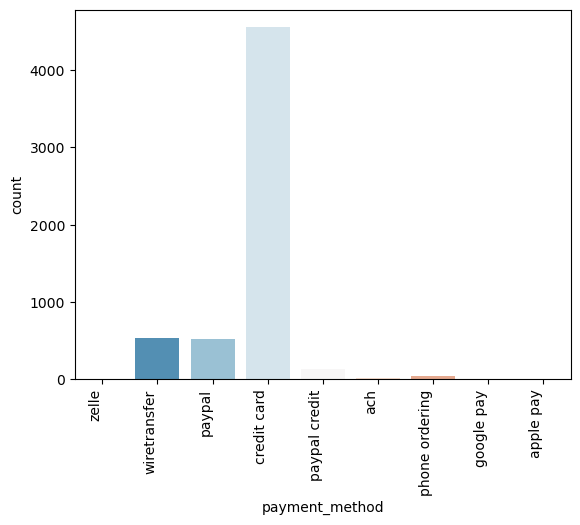

In [31]:
ax = sns.countplot(x='payment_method', data=df, palette='RdBu_r')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

[Text(0, 0, 'wiretransfer'),
 Text(1, 0, 'credit card'),
 Text(2, 0, 'zelle'),
 Text(3, 0, 'paypal'),
 Text(4, 0, 'ach'),
 Text(5, 0, 'paypal credit'),
 Text(6, 0, 'phone ordering'),
 Text(7, 0, 'google pay')]

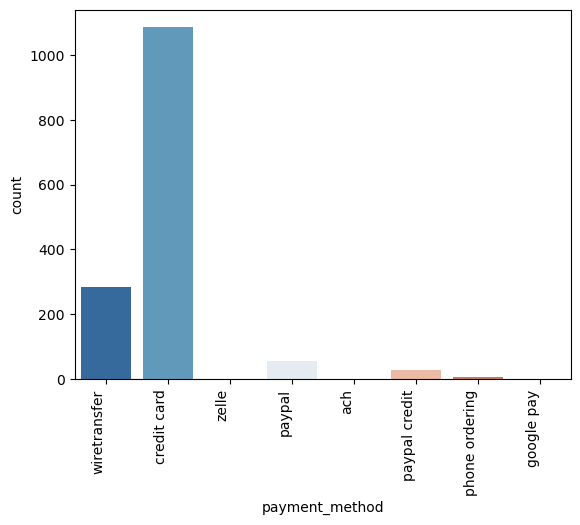

In [32]:
ax = sns.countplot(x='payment_method', data=df2, palette='RdBu_r')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

Среди методов оплаты и там и там преобладают кредитные карты, очевидно, в силу популярности данного способа оплаты в США. Данная информация тоже не дает никаких дополнительных инсайтов.

[Text(0, 0, 'will-call pick up'),
 Text(1, 0, 'canceled'),
 Text(2, 0, 'processed'),
 Text(3, 0, 'shipped'),
 Text(4, 0, 'pending fulfillment confirmation  '),
 Text(5, 0, 'waiting to be shipped '),
 Text(6, 0, 'delivered'),
 Text(7, 0, 'declined'),
 Text(8, 0, 'cs failed (auto)'),
 Text(9, 0, 'failed'),
 Text(10, 0, 'returned'),
 Text(11, 0, 'open'),
 Text(12, 0, 'backordered'),
 Text(13, 0, 'cs success (auto)'),
 Text(14, 0, 'awaiting call'),
 Text(15, 0, 'approved'),
 Text(16, 0, 'paid'),
 Text(17, 0, 'draft'),
 Text(18, 0, 'expired'),
 Text(19, 0, 'request'),
 Text(20, 0, 'pending deposit'),
 Text(21, 0, 'incompleted')]

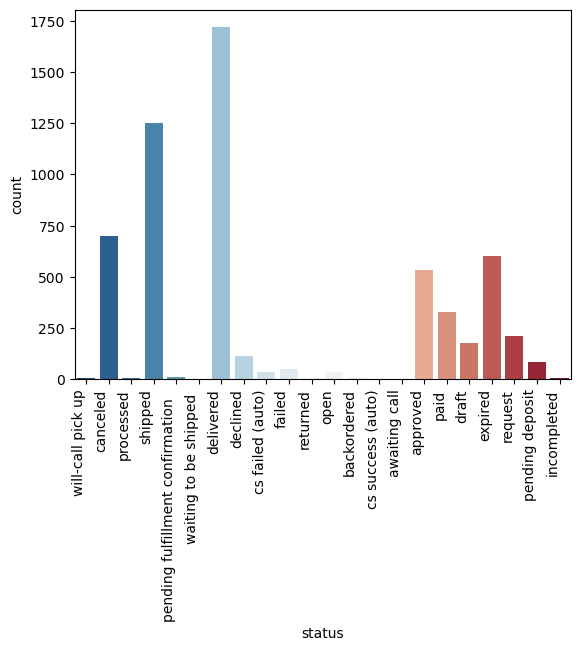

In [33]:
ax = sns.countplot(x='status', data=df, palette='RdBu_r')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


Гистограмма всех заказов по годам показывает значительный рост в два ковидных года. Впрочем показатели за 2023 года согласно ожиданиям тоже будут высокими - они уже немного превысили 2020 год в то время как прошло всего примерно полгода. То есть если год продолжится также, то 2023 год как минимум должен сравняться с 2021.

In [34]:
px.histogram(df, x="year")


In [35]:
df_timeline = df.groupby(['state', 'year', 'month', 'day']).size().reset_index(name='order_count')

In [36]:
df4 = df_timeline.groupby(['state', 'year']).size().reset_index(name='order_count')

In [37]:
px.line(df4, x='year', y='order_count', color='state',
              labels={'year': 'Год', 'order_count': 'Количество заказов'},
              title='Распределение заказов в каждом штате по годам')

Активный рост заказов пратически во всех регионах в 2021-2022 годах скорее всего вызван пандемией COVID-19 и вызванным ей кризисом. С учетом сложившей международной обстановки можно ожидать роста цен на энергоносители и, как следствие, высокий спрос на солнечные панели. В некоторых штатах, например Массачусетс, колиечство заказов в 2023 (26) году уже практически сравнялось с 2022 (31), то есть следует ожидать заметное превышение показателей предыдущего года. Однако общее количество все же не настолько велико. Ожидаемый рост закзаов в Массачусетсе может быть вызван программой SMART Program.
https://www.solar.com/learn/massachusetts-smart-solar-program-complete-overview/
Корме того, в Массачусетсе в 2019 году была выведена из эксплуатации АЭС "Пилгрим". 

In [49]:
px.histogram(df, x="month")

В распределении заказов по месяцам определенно есть сезонность. Пиковых значений количество заказов достигает весной и осенью со спадами летом и зимой. Январский спад можно объяснить праздникам - люди тратят больше денег на подарки и проиче праздничные траты. Летний спад возможно связан с тем, что из-за более высокого спроса растет цена и люди предпочитают откладывать покупки до осени.   

In [56]:
weekday_order = ["Mon", "Tue", "Wed",'Thu','Fri','Sat','Sun']
px.histogram(df, x="weekday", category_orders={'weekday': weekday_order})

Распределение заказов по дням недели в принципе демонстрирует спад на выходных, что может объясняться тем, что люди отдыхают вместе с семьей и не занимаются делами.

In [40]:
df2_timeline = df2.groupby(['state', 'year', 'month', 'day']).size().reset_index(name='order_count')
df6 = df2_timeline.groupby(['state', 'year']).size().reset_index(name='order_count')

In [41]:
px.line(df6, x='year', y='order_count', color='state',
              labels={'year': 'Год', 'order_count': 'Количество заказов'},
              title='Распределение неуспешных заказов в каждом штате по годам')

Из приведенного графика видно, что в штатах Висконсин и Нью-Йорк выросло процентное соотношение неуспешных заказов в 2023 году по сравнению с 2022 годом - их было 10 из 28, стало 17 из  21. Возможно на это также стоит обратить внимание. 

In [42]:
df.corr()

,id,total,shipping,tax,link,energy storage,solar panels,inverters,solar batteries,solar charge controllers,solar system addons,solar panel systems,wholesale solar panels,racking,year,month,day
id,1.000000,-0.153986,-0.023180,-0.033408,-0.955934,NaN,-0.125259,-0.151477,-0.039540,-0.000955,-0.153613,-0.304939,-0.031349,-0.139800,-0.108713,-0.058511,-0.004382
total,-0.153986,1.000000,0.063466,0.236616,0.017255,NaN,0.780826,0.195329,0.043671,-0.005997,0.125088,0.036058,0.293306,0.110987,0.097677,-0.022049,0.004971
shipping,-0.023180,0.063466,1.000000,0.087513,0.039346,NaN,0.041740,0.018848,0.006442,0.055378,0.017517,-0.002300,0.088560,0.027929,-0.040618,-0.029171,-0.025239
tax,-0.033408,0.236616,0.087513,1.000000,0.004483,NaN,0.247727,0.081444,0.001465,-0.008223,0.024722,-0.018172,0.033992,0.021247,0.027499,-0.026573,0.020705
link,-0.955934,0.017255,0.039346,0.004483,1.000000,NaN,-0.005690,-0.011410,0.027851,-0.018703,-0.033746,NaN,0.023457,-0.054162,0.109266,-0.036214,0.014279
energy storage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
solar panels,-0.125259,0.780826,0.041740,0.247727,-0.005690,NaN,1.000000,0.048108,-0.014121,-0.010817,0.048426,-0.019509,-0.008831,0.050564,0.031635,-0.007804,0.011631
inverters,-0.151477,0.195329,0.018848,0.081444,-0.011410,NaN,0.048108,1.000000,-0.000246,-0.009582,0.394626,0.121422,0.203138,0.225297,0.075297,0.036016,-0.003055
solar batteries,-0.039540,0.043671,0.006442,0.001465,0.027851,NaN,-0.014121,-0.000246,1.000000,0.005462,0.002318,-0.014653,-0.003841,0.000282,-0.056034,0.004028,0.000615
solar charge controllers,-0.000955,-0.005997,0.055378,-0.008223,-0.018703,NaN,-0.010817,-0.009582,0.005462,1.000000,-0.010980,-0.019527,-0.003282,-0.009954,-0.039667,0.002536,0.000376


Матрица корреляции не показывает никаких необычных и/или интересных взаимосвязей. 

### Выводы

Согласно предварительному анализу можно вызвинуть две большие группы факторов, влияющих на спрос в том или ином регионе: глобальные и локальные.

Глобальные факторы это пандемия, международная обстановка, рост цен на энергоресурсы, государственная политика в области энергетики и прочее. 
По данным U.S. Energy Information Administration в 2022 году производство из возобновляемых источников энергии впервые превысило показатели угля и атомной промышленности. Конечно, основной вклад в эту генерацию внесли ветряки, но если посмотреть кривую генерации по годам и по источникам, то производство солнечной энергии повторяет форму кривой производства ветряков. 
https://www.eia.gov/todayinenergy/detail.php?id=55960#
Следует ожидать, что влияние глобальных факторов на спрос в 2023 году также будет значительным и спрос будет расти. 


К локальным факторам можно отнести стимулирующие экономические программы в отдельных штатах, изменения в структуре генерации (например, вывод из эксплуатации АЭС или другого крупного источника энергии и т.д.). Нужно заметить, что эти факторы не оказывают немедленного воздействия на спрос, а начинают полижительно влиять на него спустя пару лет. В этой связи интересны Техас и Массачусетс. Можно прогнозировать заметный рост числа заказов в этих штатах.

Также можно отдельно выделить социальные факторы, в частности повышение осведомленности населения о преимуществах солнечной энергии и ее потенциале, экологическая повестка (стоит отметить, что непосредственного влияния изменения климата, т.е. погоды не спрос не отмечено, но данная тема активно обсуждается в СМИ, соцсетям и проч. то есть оказывает сильное информационное воздействие). Потребители, стремящиеся к уменьшению своего углеродного следа и переходу на чистые источники энергии, могут обратить внимание на солнечные панели. Особенно сильна экологическая повестка в некоторых странах Европы, в частности, в Германии, Сканлинавских странах и т.д.

Следует отметить, что по прогнозам того же U.S. Energy Information Administration генерация солнечной энергии до 2050 года будет неуклонно расти и уже в 2026 году она превысит ветер.

In [43]:
generation = pd.read_excel('aeotab16.xlsx', sheet_name='Generation (billion kwh)')

In [44]:
generation

,Generation (billion kilowatthours),2022,2023,2024,2025,2026,2027,2028,2029,2030,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Conventional Hydroelectric Power,276.156464,282.251984,291.519806,299.520996,300.167236,300.149414,297.920441,297.589355,296.070435,...,288.468079,288.645630,288.161804,288.090759,287.921112,287.106110,286.857147,286.689941,286.087311,284.707062
1,Geothermal,15.603487,15.400090,16.169508,16.901815,17.687540,18.305525,18.915640,19.998245,20.952909,...,28.520941,29.272818,29.809298,30.455145,31.489103,32.962669,34.464630,35.393120,36.441025,37.210800
2,Municipal Waste 8/,14.342225,15.435862,16.139072,16.759008,17.384197,18.277134,18.956875,19.820156,20.754488,...,32.171844,33.174538,34.167889,35.193752,36.232880,36.886093,37.666168,38.358967,39.054371,39.846436
3,Wood and Other Biomass,39.566422,39.623394,38.606037,38.847717,38.839378,38.904152,38.541351,38.453823,38.591454,...,40.596848,40.701851,40.896297,41.008865,41.097885,41.709923,41.958508,42.129211,42.704391,43.016983
4,Solar 5/,205.036057,256.960632,340.972778,467.746643,609.459045,740.283875,822.938049,875.135010,911.156799,...,1407.484131,1439.816162,1477.380127,1526.935791,1572.937134,1636.637085,1681.697754,1724.794678,1774.680420,1828.002930
5,Wind,439.668884,466.852814,472.504028,512.591614,582.461121,670.535767,781.728821,876.909973,967.412842,...,1156.190552,1157.675537,1163.892822,1173.834595,1181.835327,1183.099365,1194.873413,1206.112305,1209.350586,1217.713257
6,"Total Generation, All Sectors",990.373535,1076.524780,1175.911255,1352.367798,1565.998535,1786.455811,1979.001221,2127.906494,2254.938965,...,2953.432373,2989.286621,3034.308105,3095.519043,3151.513428,3218.401367,3277.517578,3333.478271,3388.318115,3450.497559
